In [9]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure

In [10]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [11]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [12]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    for x in range(heigh):
        for y in range(width):
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
    
    return tmp

In [13]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [16]:
def main():
    to_show = 2
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()

    for x in range(to_show):
        print("Image no ", x)
        classes = get_vals(masks[:,:,x])
        for j in classes:
            tmp = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            print("class ", j)
            show_slice_mask(tmp, masks[:,:,x])
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])

Image no  0
class  2.0


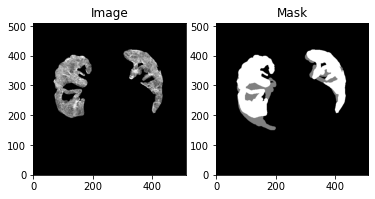

class  1.0


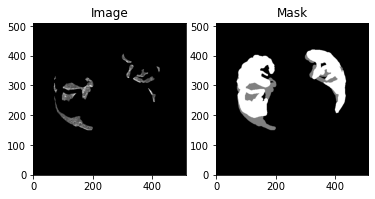

Image no  1
class  2.0


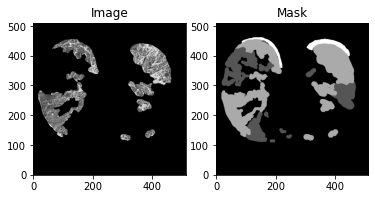

class  1.0


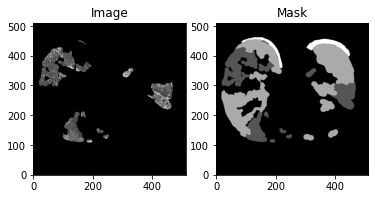

class  3.0


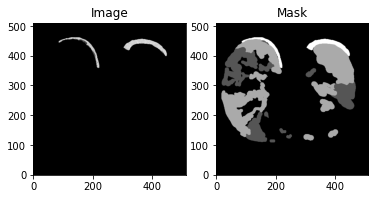

In [17]:
main()